## Цель проекта

Цель данного проекта - предсказание вероятности покупки пользователем в течение 90 дней. 

Перед тем, как начать исследование в первой части нам будет необходимо провести предобработку данных. Для начала мы прочитаем все датасеты и проверим названия столбцов и тип данных. Мы проведем поиск пропусков, заполним их, найдем явные и неявные дубликаты и аномалии.

Далее мы проведем исследовательский анализ данных и визуализируем все признаки, которые описывают покупки пользователей - цену, количество товаров, самые популярые каналы рассылки и типы действия. Мы также создадим новые признаки - кол-во лет между первой и последней рассылкой пользователю, количество типов действий, мода типов действий, последний год рассылки . Исследовательский анализ поможет выяснить, сколько в среднем тратят пользователи на одну покупку, сколько товаров они приобретают, через какой канал идет наибольшее количество рассылок и какое действие чаще всего совершают с ними.

Следующим нашим шагом будет корреляционный анализ признаков в датасете. Мы изучим взаимосвязь между признаками и рассчитаем коэффициенты корреляции. Мы изучим мультиколлинеарность между входными признаками. Мы построим диаграммы рассеивания для всех  признаков и целевого признака покупательская активность. В конце анализа мы опишем связь между входными и целевым признаками.

Для поиска лучшей модели, которая сможет прогнозировать вероятность покупки, мы будем использовать пайплайн. С помощью него мы закодируем количественные и категориальные признаки, и обучим наши тренировочные данные на нескольких моделях. С помощью RandomizedSearchCV мы переберем все модели и их гиперпараметры, и найдем модель с лучшей ROC-AUC метрикой на кросс-валидационной выборке. 

Мы построим график важности  признаков по величине коэффициентов узнаем, какие признаки больше всего влияют на вероятность покупки. 

## Загрузка и чтение данных

In [1]:
!pip install phik -q
!pip install missingno
!pip install -U scikit-learn
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import phik
import warnings
import lightgbm as lgb
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import precision_recall_curve, confusion_matrix,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [4]:
def datetime(data, column):
    data[column] = pd.to_datetime(data[column], format = '%Y-%m-%d')

In [5]:
def hist(column, x, y, title):
    plt.hist(column)
    plt.ticklabel_format(style='plain')
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title);

In [6]:
def pie(numbers, labels, title):
    subs_pivot = numbers
    fig, ax = plt.subplots()
    ax.pie(subs_pivot, labels = labels, shadow=True, autopct='%1.0f%%')
    plt.title(title);

In [7]:
def scatter(x, y, hue,title):
    sns.scatterplot(x = df[x], y =df[y], hue = df[hue]).set_title(title);

In [8]:
purchases = pd.read_csv('/Users/macbook/Desktop/marketing/apparel-purchases.csv')
messages = pd.read_csv('/Users/macbook/Desktop/marketing/apparel-messages.csv')
target = pd.read_csv('/Users/macbook/Desktop/marketing/apparel-target_binary.csv')

In [9]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [10]:
purchases.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


Данные из таблицы с историей покупок нуждаются только в изменении типы данных столбца с датой.

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [12]:
messages.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


Данные из таблицы с историей рекламных рассылок нуждаются только в изменении типы данных столбца с датой.

In [13]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [14]:
target.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


## Предобработка данных

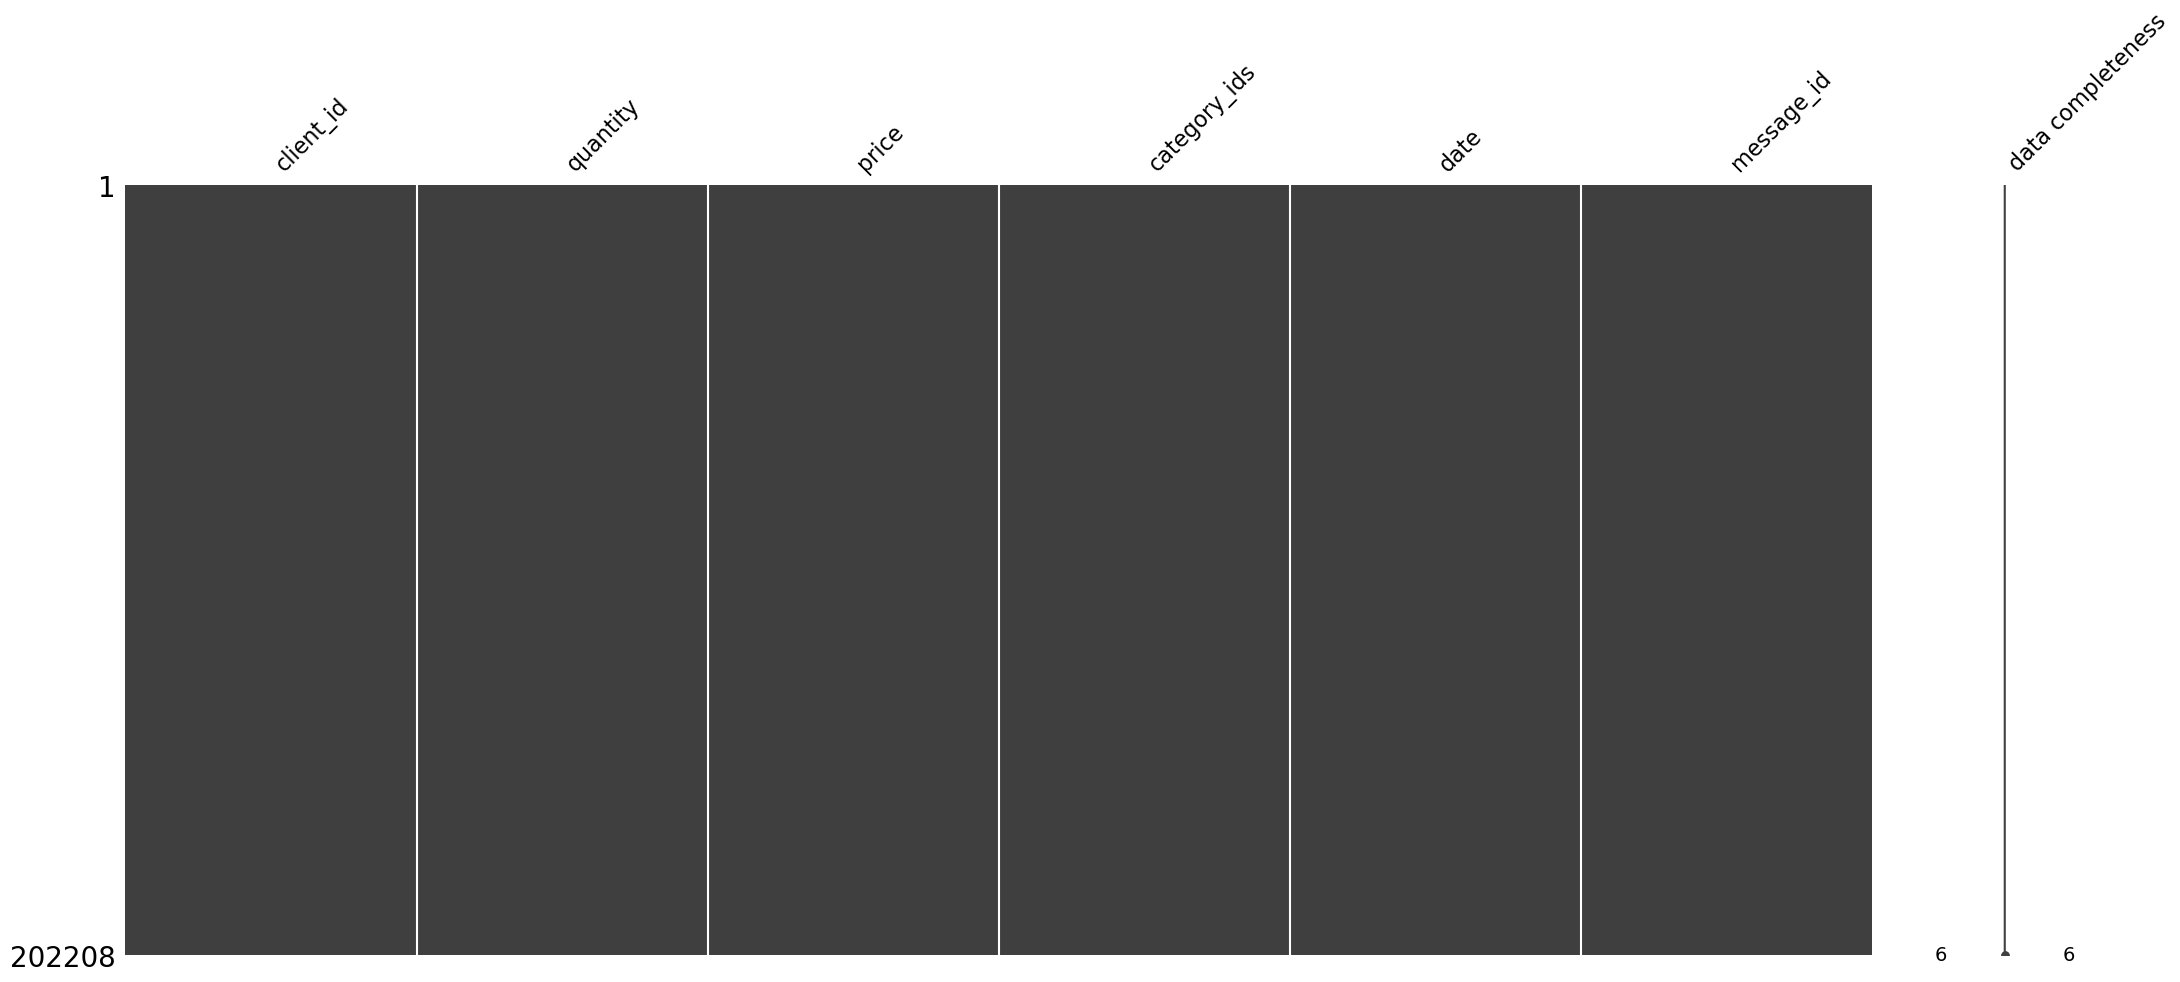

In [15]:
msno.matrix(purchases, labels=True);

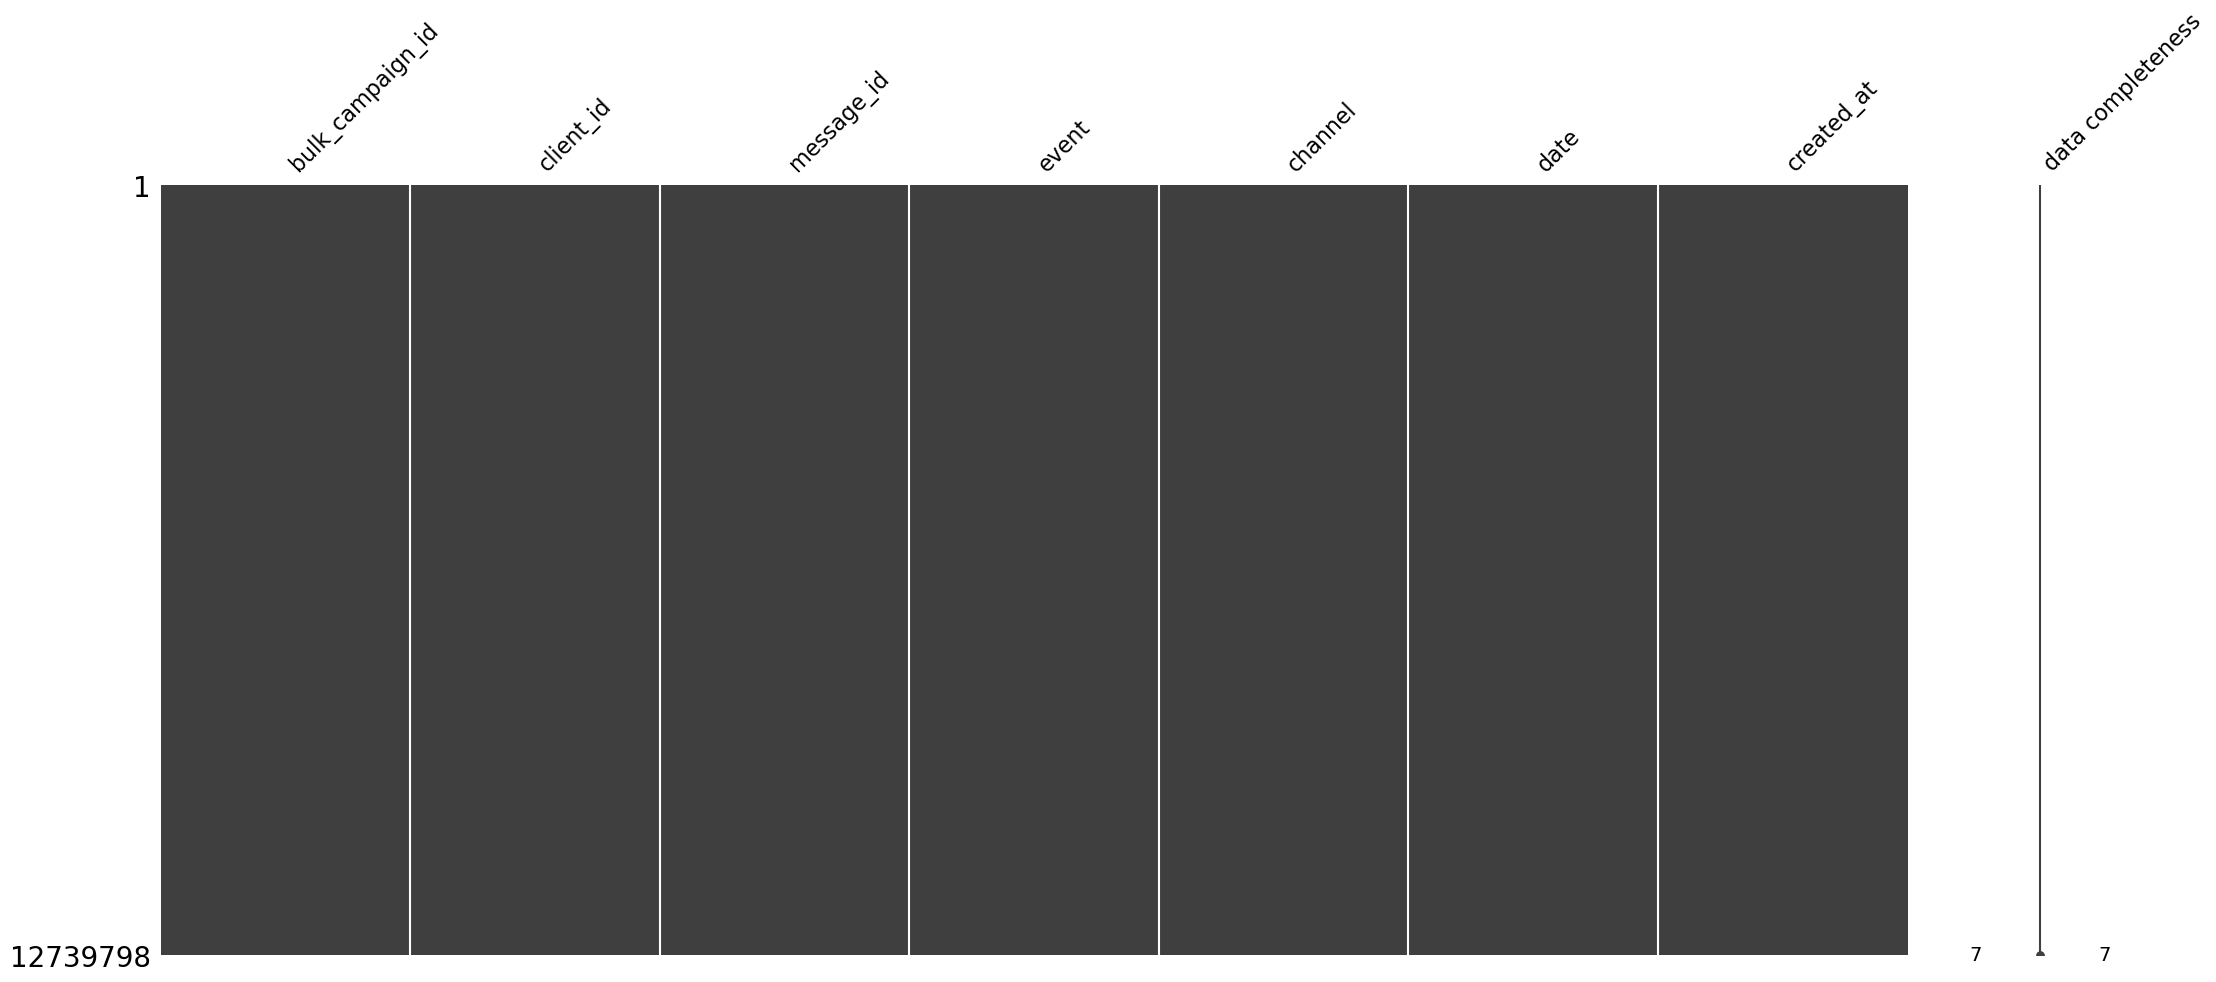

In [16]:
msno.matrix(messages, labels=True);

Пропуски в обоих датасетах отсутствуют.

In [17]:
print('Кол-во дубликатов в purchases:', purchases.duplicated().sum())
print('Кол-во дубликатов в messages:', messages.duplicated().sum())

Кол-во дубликатов в purchases: 73020
Кол-во дубликатов в messages: 48610


In [18]:
purchases[purchases.duplicated()]

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.0,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.0,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
59,1515915625468126078,1,1499.0,"['4', '28', '275', '421']",2022-05-17,1515915625468126078-4439-6283411f7c0cc
62,1515915625468141317,1,49.0,"['4', '27', '38', '481']",2022-05-17,1515915625468141317-4439-6283412e01078
...,...,...,...,...,...,...
202200,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202201,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8


In [19]:
#избавляемся от дубликатов
purchases.drop_duplicates(keep='first', inplace = True)

In [20]:
messages[messages.duplicated()]


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
966466,5723,1515915625483569932,1515915625483569932-5723-62e2af0790ad5,click,mobile_push,2022-07-28,2022-07-28 16:07:12
967282,5723,1515915625736038297,1515915625736038297-5723-62e2af0a17cba,click,mobile_push,2022-07-28,2022-07-28 16:09:56
967567,5723,1515915625753898206,1515915625753898206-5723-62e2af0a21ecd,click,mobile_push,2022-07-28,2022-07-28 16:12:24
967904,5723,1515915625626349443,1515915625626349443-5723-62e2af09c0fd3,click,mobile_push,2022-07-28,2022-07-28 16:15:02
...,...,...,...,...,...,...,...
12739558,14657,1515915625566604535,1515915625566604535-14657-65cdd3746b1d9,open,email,2024-02-15,2024-02-15 18:20:59
12739660,14648,1515915625559148104,1515915625559148104-14648-65cdb715ea3dd,click,mobile_push,2024-02-15,2024-02-15 20:10:39
12739720,14600,1515915625468103375,1515915625468103375-14600-65c2038646d16,click,mobile_push,2024-02-15,2024-02-15 21:52:00
12739722,14607,1515915625468103375,1515915625468103375-14607-65c33b1f402bb,click,mobile_push,2024-02-15,2024-02-15 21:52:00


In [21]:
messages[(messages['message_id'] == '1515915625554535987-5723-62e2af08e00da') & (messages['event'] == 'click')]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56


In [22]:
messages.drop_duplicates(keep='first', inplace = True)

In [23]:
#сбрасываем индексы
messages.reset_index(inplace=True)
purchases.reset_index(inplace=True)

In [24]:
messages.head(5)

,index,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [25]:
purchases.head(5)

,index,client_id,quantity,price,category_ids,date,message_id
0,0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [26]:
#с помощью готовой функции меняем типы данных у двух столбцов с данными
datetime(purchases,'date')
datetime(messages, 'date')

In [27]:
#вручную меняем тип данных у created_at из-за времени
messages['created_at'] = pd.to_datetime(messages['created_at'], format = '%Y-%m-%d %H:%M:%S')

In [28]:
#оставляем только год, так как только эта информация пригодится нам для анализа
messages['year_date_m'] = messages['date'].dt.year
messages['year_created_m'] = messages['created_at'].dt.year

In [29]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129188 entries, 0 to 129187
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         129188 non-null  int64         
 1   client_id     129188 non-null  int64         
 2   quantity      129188 non-null  int64         
 3   price         129188 non-null  float64       
 4   category_ids  129188 non-null  object        
 5   date          129188 non-null  datetime64[ns]
 6   message_id    129188 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 6.9+ MB


In [30]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691188 entries, 0 to 12691187
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   index             int64         
 1   bulk_campaign_id  int64         
 2   client_id         int64         
 3   message_id        object        
 4   event             object        
 5   channel           object        
 6   date              datetime64[ns]
 7   created_at        datetime64[ns]
 8   year_date_m       int32         
 9   year_created_m    int32         
dtypes: datetime64[ns](2), int32(2), int64(3), object(3)
memory usage: 871.4+ MB


In [31]:
#соединяем таблицы по message_id, с параметром how='inner'
df = purchases.merge(messages, on = 'message_id', how='inner')

#изначально я соединяла столбцы по client_id, но у меня было ~45млн строк и метрика была хуже, решила переделать так

In [32]:
#таблица объединена успешно
df.head(5)

,index_x,client_id_x,quantity,price,category_ids,date_x,message_id,index_y,bulk_campaign_id,client_id_y,event,channel,date_y,created_at,year_date_m,year_created_m
0,7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b,153130,4172,1515915625490739153,open,email,2022-05-27,2022-05-27 07:52:08,2022,2022
1,11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4680553,2090,1515915625491869271,click,email,2023-04-12,2023-04-12 08:25:33,2023,2023
2,11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,4813199,2090,1515915625491869271,click,email,2023-04-18,2023-04-18 11:47:45,2023,2023
3,11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,5694812,2090,1515915625491869271,click,email,2023-06-13,2023-06-13 11:10:41,2023,2023
4,11,1515915625491869271,2,599.0,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f,10973168,2090,1515915625491869271,click,email,2023-12-28,2023-12-28 11:25:50,2023,2023


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012697 entries, 0 to 1012696
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   index_x           1012697 non-null  int64         
 1   client_id_x       1012697 non-null  int64         
 2   quantity          1012697 non-null  int64         
 3   price             1012697 non-null  float64       
 4   category_ids      1012697 non-null  object        
 5   date_x            1012697 non-null  datetime64[ns]
 6   message_id        1012697 non-null  object        
 7   index_y           1012697 non-null  int64         
 8   bulk_campaign_id  1012697 non-null  int64         
 9   client_id_y       1012697 non-null  int64         
 10  event             1012697 non-null  object        
 11  channel           1012697 non-null  object        
 12  date_y            1012697 non-null  datetime64[ns]
 13  created_at        1012697 non-null  dateti

In [34]:
#сразу удаляем ненужные столбцы
df.drop(columns=['client_id_y','index_x','index_y','bulk_campaign_id'],axis=1,inplace=True)

In [35]:
df.columns

Index(['client_id_x', 'quantity', 'price', 'category_ids', 'date_x',
       'message_id', 'event', 'channel', 'date_y', 'created_at', 'year_date_m',
       'year_created_m'],
      dtype='object')

In [36]:
#переименовываем столбец с идентификатором клиента для дальнейшнего объединения
df.rename(columns={'client_id_x': 'client_id'}, inplace=True)

In [37]:
#добавляем столбец с целевым признаком
df = df.merge(target, on = 'client_id')

In [38]:
df.columns

Index(['client_id', 'quantity', 'price', 'category_ids', 'date_x',
       'message_id', 'event', 'channel', 'date_y', 'created_at', 'year_date_m',
       'year_created_m', 'target'],
      dtype='object')

In [39]:
df['category_ids'].unique()

array(["['2', '18', '123', '451']", "['4', '27', '350', '1392']",
       "['5562', '5634', '5579', '710']",
       "['5562', '5634', '5568', '957']",
       "['5562', '5634', '5693', '636']", "['4', '28', '340', '1312']",
       "['4', '28', '156', '416']", "['4', '28', '124', '415']",
       "['5562', '5633', '5692', '637']", "['4', '27', '202', '701']",
       "['2', '18', '258', '1195']", "['4', '28', '275', '421']",
       "['4', '28', '249', '615']", "['4', '28', '62', '656']",
       "['4', '28', '260', '1570']", "['6060', '6058', '6065', '1848']",
       "['6060', '6058', '6065', '5847']",
       "['5562', '5630', '5667', '551']", "['4', '28', '213', '436']",
       "['5562', '5630', '5607', '555']", "['4', '31', '326', '505']",
       "['4', '28', '260', '420']", "['4', '28', '343', '425']",
       "['2', '18', '258', '441']", "['4', '28', '57', '431']",
       "['4', '28', '275', '673']", "['4', '31', '324', '1431']",
       "['4', '31', '324', '466']", "['4', '28', '244', '43

Мы видим два значения -[None] и [], которые необходимо заменить на nan, а simpleimputer заменит их на моду. Но перед этим оставим в столбце только главную категорию и первую подкатегорию, чтобы использовать этот столбец для анализа. Если этого не сделать, ohe кодировщик создаст слишком много категорий, и моделям будет тяжело обучаться.

In [40]:
df['category_ids'] = df['category_ids'].map(lambda x: ','.join(x.split(',')[0:2]))

In [41]:
df['category_ids'] = df['category_ids'].replace('[]',np.nan)
df['category_ids'] = df['category_ids'].replace('[None]',np.nan)

In [42]:
df['category_ids'].head(5)

0    ['2', '18'
1    ['4', '27'
2    ['4', '27'
3    ['4', '27'
4    ['4', '27'
Name: category_ids, dtype: object

In [43]:
pivot = (df.pivot_table(index='client_id', values=['event','year_created_m','quantity','price'],
                        aggfunc={'event':['count',lambda x: x.mode()],
                                 'year_created_m':['min','max'],
                                 'price':'sum',
                                 'quantity':'sum'})).reset_index()

Чтобы уменьшить количество строк с одним клиентом, используем сводную таблицу где считатаем типы действий, моду типов действий,первую и последнюю рекламную рассылку, сумму кол-ва товаров и сумму стоимости на одного клиента.

In [44]:
pivot.head(5)

client_id                          event          price quantity  \
                                           <lambda_0> count      sum      sum   
0  1515915625468060902                       purchase    55  52745.0       55   
1  1515915625468061003  [click, open, purchase, send]    24  56540.0       24   
2  1515915625468061100  [click, open, purchase, send]     4   4196.0        4   
3  1515915625468061170                          click    37  63527.0       37   
4  1515915625468061514  [click, open, purchase, send]     4   3996.0        4   

  year_created_m        
             max   min  
0           2022  2022  
1           2023  2023  
2           2024  2024  
3           2023  2023  
4           2022  2022

In [45]:
#избавляемся от доп уровня
pivot.columns = pivot.columns.droplevel()

In [46]:
#создаем новый столбец - разница (в годах) между первой и последней рассылкой, столбец min будет удален
pivot['diff_created_at'] = pivot['max'] - pivot['min']

In [47]:
pivot.head(5)

,,<lambda_0>,count,sum,sum,max,min,diff_created_at
0,1515915625468060902,purchase,55,52745.0,55,2022,2022,0
1,1515915625468061003,"[click, open, purchase, send]",24,56540.0,24,2023,2023,0
2,1515915625468061100,"[click, open, purchase, send]",4,4196.0,4,2024,2024,0
3,1515915625468061170,click,37,63527.0,37,2023,2023,0
4,1515915625468061514,"[click, open, purchase, send]",4,3996.0,4,2022,2022,0


In [48]:
#даем новые названия столбцам
pivot.columns = ['client_id','event_mode','event_count','price_sum',
             'quantity_sum','max_created_at','min_created_at','diff_created_at']

In [49]:
pivot.columns

Index(['client_id', 'event_mode', 'event_count', 'price_sum', 'quantity_sum',
       'max_created_at', 'min_created_at', 'diff_created_at'],
      dtype='object')

In [50]:
#изменяем тип данных с array на str
pivot['event_mode'] = pivot['event_mode'].apply(str)

In [51]:
pivot.drop(columns=['min_created_at'], axis=1, inplace=True)

In [52]:
#добавляем сводную таблицу к нашей основной
df = df.merge(pivot, on='client_id')

In [53]:
df.head(5)

,client_id,quantity,price,category_ids,date_x,message_id,event,channel,date_y,created_at,year_date_m,year_created_m,target,event_mode,event_count,price_sum,quantity_sum,max_created_at,diff_created_at
0,1515915625490739153,1,1999.0,"['2', '18'",2022-05-16,1515915625490739153-4172-626b943cc789b,open,email,2022-05-27,2022-05-27 07:52:08,2022,2022,0,open,1,1999.0,1,2022,0
1,1515915625491869271,2,599.0,"['4', '27'",2022-05-16,1515915625491869271-2090-61a72488d6a0f,click,email,2023-04-12,2023-04-12 08:25:33,2023,2023,0,click,4,2396.0,8,2023,0
2,1515915625491869271,2,599.0,"['4', '27'",2022-05-16,1515915625491869271-2090-61a72488d6a0f,click,email,2023-04-18,2023-04-18 11:47:45,2023,2023,0,click,4,2396.0,8,2023,0
3,1515915625491869271,2,599.0,"['4', '27'",2022-05-16,1515915625491869271-2090-61a72488d6a0f,click,email,2023-06-13,2023-06-13 11:10:41,2023,2023,0,click,4,2396.0,8,2023,0
4,1515915625491869271,2,599.0,"['4', '27'",2022-05-16,1515915625491869271-2090-61a72488d6a0f,click,email,2023-12-28,2023-12-28 11:25:50,2023,2023,0,click,4,2396.0,8,2023,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012697 entries, 0 to 1012696
Data columns (total 19 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   client_id        1012697 non-null  int64         
 1   quantity         1012697 non-null  int64         
 2   price            1012697 non-null  float64       
 3   category_ids     985914 non-null   object        
 4   date_x           1012697 non-null  datetime64[ns]
 5   message_id       1012697 non-null  object        
 6   event            1012697 non-null  object        
 7   channel          1012697 non-null  object        
 8   date_y           1012697 non-null  datetime64[ns]
 9   created_at       1012697 non-null  datetime64[ns]
 10  year_date_m      1012697 non-null  int32         
 11  year_created_m   1012697 non-null  int32         
 12  target           1012697 non-null  int64         
 13  event_mode       1012697 non-null  object        
 14  ev

In [55]:
#удаляем столбцы, которые нам больше не пригодятся 
df.drop(columns = [ 'quantity','price','date_x','date_y','message_id',
                   'year_date_m','created_at','date_x','date_y'],axis=1, inplace=True)

In [56]:
df.columns

Index(['client_id', 'category_ids', 'event', 'channel', 'year_created_m',
       'target', 'event_mode', 'event_count', 'price_sum', 'quantity_sum',
       'max_created_at', 'diff_created_at'],
      dtype='object')

In [57]:
#с помощью сводной таблицы удалось выявить 756 тысячи дубликатов
df.duplicated().sum()

749395

In [58]:
#избавляемся от них
df.drop_duplicates(inplace=True)

In [59]:
df.shape[0]

263302

In [60]:
df.head(5)

,client_id,category_ids,event,channel,year_created_m,target,event_mode,event_count,price_sum,quantity_sum,max_created_at,diff_created_at
0,1515915625490739153,"['2', '18'",open,email,2022,0,open,1,1999.0,1,2022,0
1,1515915625491869271,"['4', '27'",click,email,2023,0,click,4,2396.0,8,2023,0
5,1515915625566606509,"['5562', '5634'",open,email,2022,0,open,4,2046.0,4,2022,0
9,1515915625468094895,"['4', '28'",open,email,2022,0,click,11,10089.0,11,2022,0
10,1515915625468094895,"['4', '28'",click,email,2022,0,click,11,10089.0,11,2022,0


Наши данные готовы к исследовательскому анализу.

## Исследовательский анализ данных

In [61]:
df.pivot_table(index='channel',values='client_id',aggfunc='count')

,client_id
channel,
email,191057
mobile_push,72245


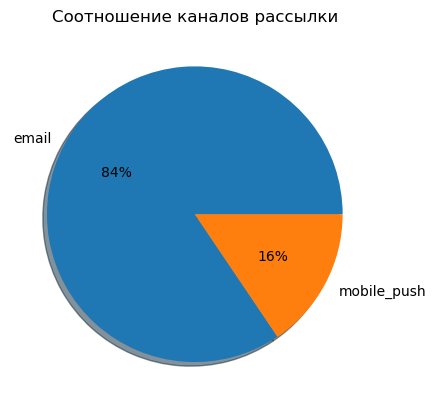

In [62]:
pie([471761,86889],['email','mobile_push'], 'Cоотношение каналов рассылки')

Большинство рекламных рассылок были доставлены через почту. 

In [63]:
df.pivot_table(index='event',values='client_id',aggfunc='count')

,client_id
event,
click,70693
complain,24
hard_bounce,141
open,51840
purchase,70391
send,70130
subscribe,6
unsubscribe,77


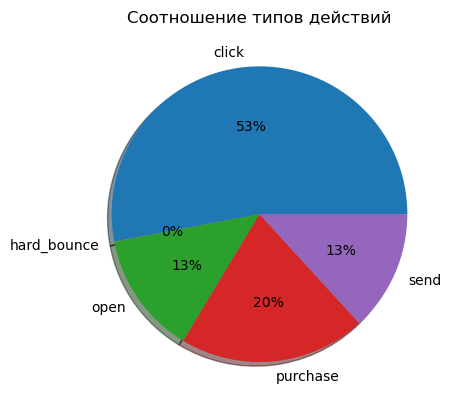

In [64]:
pie([295875,144,74662,114104,73744], ['click','hard_bounce','open','purchase','send'],
    'Соотношение типов действий')

Самый популярный тип действия - send (отправлены, но не открыты). На втором месте идет open, 25% рекламных рассылок открываются пользователями. Только 11% рассылок побудили пользователей на покупку товара. На 20% рассылок пользователи заходят на сайт. 3% рассылок входят в категорию hard bounce, то есть не доставлены адресу. Остальные категории - close,complain, soft bounce, subscribe и unsubscribe - не входят в статистику из-за слишком малых значений.

In [65]:
df.pivot_table(index='year_created_m',values='client_id',aggfunc='count')

,client_id
year_created_m,
2022,125558
2023,125954
2024,11790


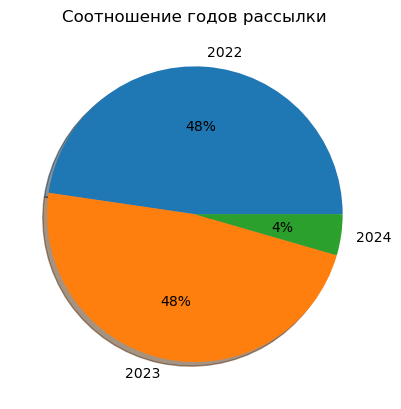

In [66]:
pie([125558,125954,11790], [2022,2023,2024],
    'Соотношение годов рассылки')

Большинство рекламных рассылок были отправлены в 2023 году, на втором месте - 2022. Всего 24% рассылок были отправлены в 2024, но это также можно связать с тем, что данные были получены еще до конца года. 

In [67]:
df.pivot_table(index='target',values='client_id',aggfunc='count')

,client_id
target,
0,256581
1,6721


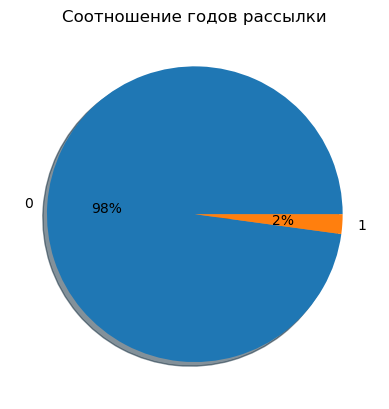

In [68]:
pie([546646,12004], [0,1],
    'Соотношение годов рассылки')

Только 3% пользователей совершили покупку после рекламной рассылки. 

In [69]:
df.pivot_table(index='diff_created_at',values='client_id',aggfunc='count')

,client_id
diff_created_at,
0,229836
1,30477
2,2989


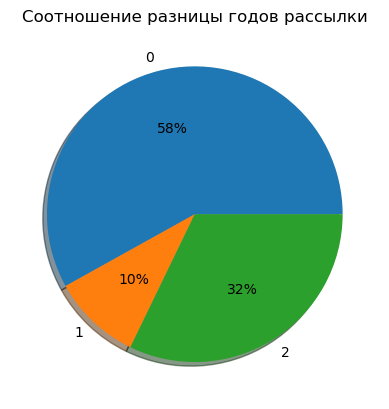

In [70]:
pie([324431,54460,179759], [0,1,2],
    'Соотношение разницы годов рассылки')

Большинство пользователей получают рассылки на протяжении двух лет. Только 3% пользователей начали их получать в 2024 году. 

In [71]:
df.pivot_table(index='category_ids',
                      values='client_id',aggfunc='count').sort_values(by='client_id',ascending=False).head(20)

,client_id
category_ids,
"['4', '28'",106446
"['2', '18'",36498
"['4', '27'",14211
"['5562', '5630'",14065
"['4', '31'",13628
"['5562', '5631'",12351
"['5562', '5589'",6637
"['4', '29'",6011
"['5562', '5633'",5604


Перед нами двадцать самых популярных категорий купленных товаров. Практически все значения находятся в 4 категории и 28 подкатегории. 

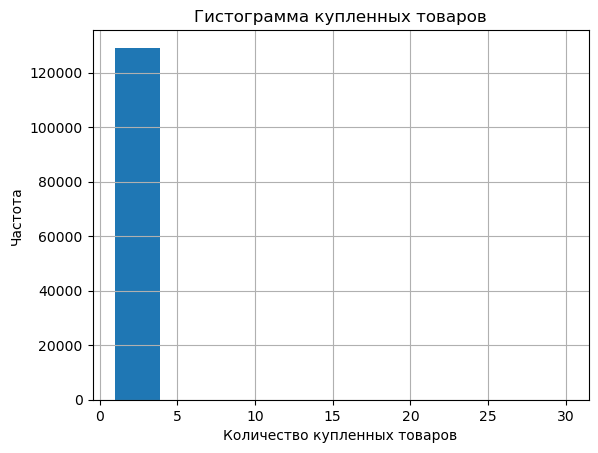

In [72]:
hist(purchases['quantity'],'Количество купленных товаров','Частота',
     'Гистограмма купленных товаров')

Чаще всего пользователи покупают от 1 до 4 товаров за покупку.

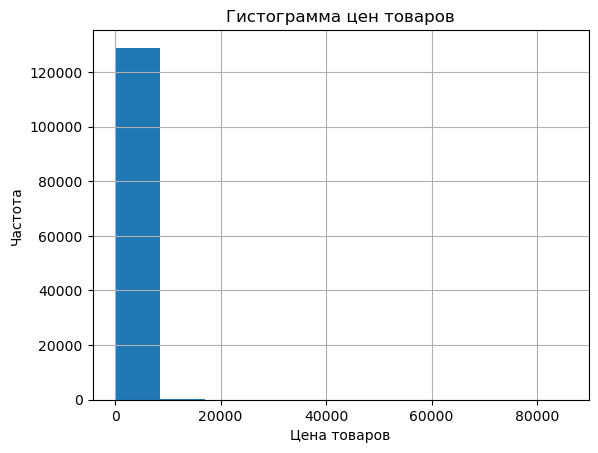

In [73]:
hist(purchases['price'],'Цена товаров','Частота',
     'Гистограмма цен товаров')

Пользователи тратят от 1 до 10 000 тысяч рублей за одну транзакцию.

Мы выяснили, что чаще всего пользователи получают рекламную рассылку с помощью почту, также большинство рассылок не открываются клиентами, но 26% их открывают, а еще 20% кликают на товары в этих рассылках. Больше всего рассылок пользователи получили в 2022 и 2023 годах. Подавляющее большинство клиентов получают рассылки уже два года. Чаще всего пользователи приобретают от 1 до 4 товаров и тратят на это до 10 000 тысяч рублей. 

## Корреляционный анализ данных

interval columns not set, guessing: ['client_id', 'year_created_m', 'target', 'event_count', 'price_sum', 'quantity_sum', 'max_created_at', 'diff_created_at']


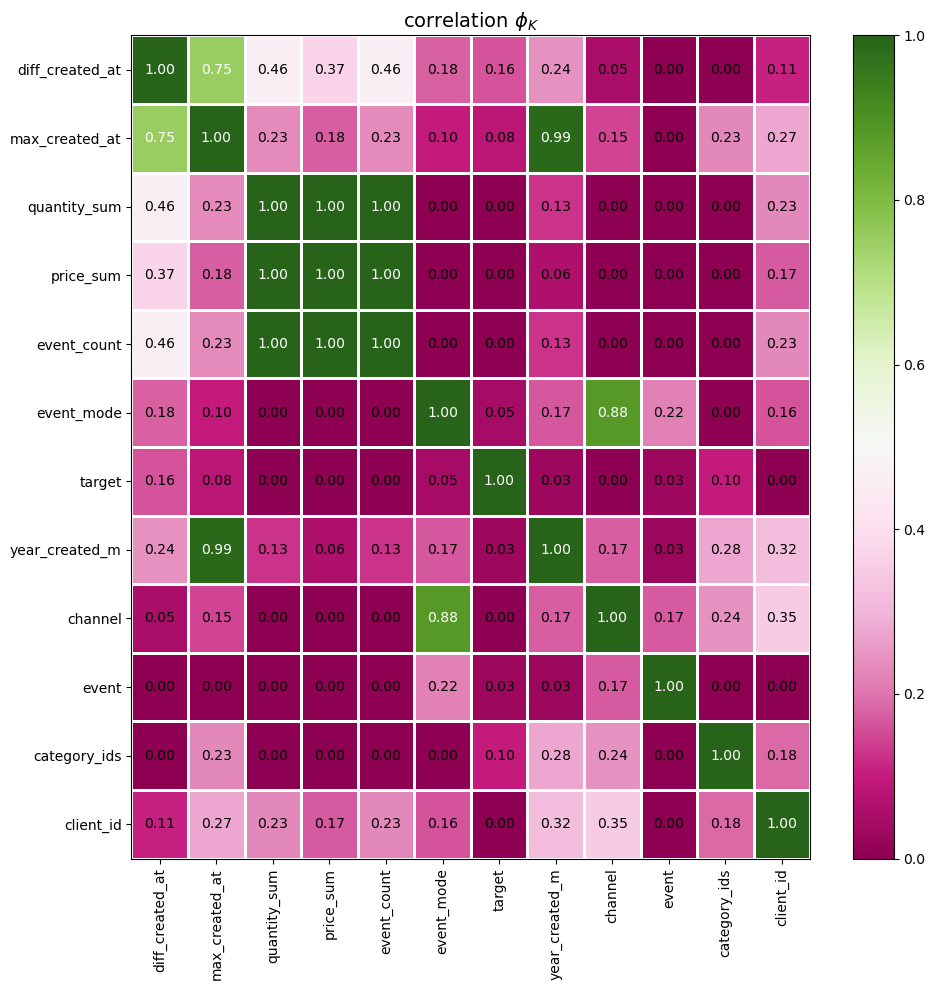

In [74]:
phik_overview = df.sample(1000).phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='PiYG', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

Корреляционный анализ показывает нам, что наш целевой признак больше всех коррелирует с количеством товаров за покупку, а также с кол-вом типов действий и  стоимостью. Мы видим небольшую корреляцию фактом покупки с модой типа действия и разницой между первой и последней рассылкой. 
Такие признаки как кол-во товаров, стоимость и кол-во типов действий сильно мультиколлериуют между собой. Но, так как мы будем использовать модели классификации, нам не страшна мультиколлинеарность.
Призанк разница между первой и второй рассылкой также коррелирует со многими признаками из нашего датасета.

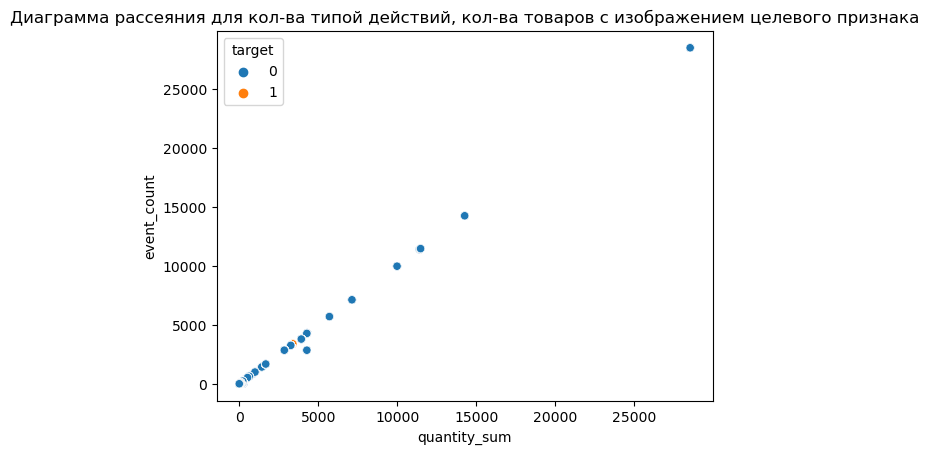

In [75]:
scatter('quantity_sum','event_count','target',
       'Диаграмма рассеяния для кол-ва типой действий, кол-ва товаров с изображением целевого признака')

#я очень хотела сделать скаттер плоты, но я из-за слишком малого кол-ва target==1 не видела никакой связи,я смогла сделать анализ только на основе матрицы...

## Обучение моделей

In [76]:
df.drop(columns=['event','channel','year_created_m'],axis=1,inplace=True)

Удаляем еще два столбца, чтобы уменьшить количество строк,удаляя дубликаты.

In [77]:
df.duplicated().sum()

194718

In [78]:
df.drop_duplicates(inplace=True)

In [79]:
df.shape[0]

68584

In [80]:
df['client_id'].duplicated().sum()

18995

#в целом моя тактика заключалась в том, чтобы максимально объединить значения признаков для одного пользователя, чтобы у него не было дубликатов, но в итоге все равно осталось 19 тысяч дубликатов по айди клиента, и я их просто удалила
я этим конечно очень недовольна как и в целом работой с этим проектом, но мне не хватило времени на то, чтобы полностью с этими датасетами разобраться, этот проект достаточно тяжело мне дался. Заранее извиняюсь...

In [81]:
df.drop_duplicates(subset='client_id',inplace=True)

In [82]:
df.set_index('client_id', inplace=True)

In [83]:
df.head(5)

,category_ids,target,event_mode,event_count,price_sum,quantity_sum,max_created_at,diff_created_at
client_id,,,,,,,,
1515915625490739153,"['2', '18'",0,open,1,1999.0,1,2022,0
1515915625491869271,"['4', '27'",0,click,4,2396.0,8,2023,0
1515915625566606509,"['5562', '5634'",0,open,4,2046.0,4,2022,0
1515915625468094895,"['4', '28'",0,click,11,10089.0,11,2022,0
1515915625470912412,"['4', '27'",0,['open' 'send'],6,25994.0,6,2022,0


In [84]:
df[df['target']==1].count()[0]

928

In [85]:
df[df['target']==0].count()[0]

46966

В параметрах моделей мы укажем class_weight='balanced', так как наши значения целевого признака сильно несбалансированы.

In [86]:
ohe_columns = ['category_ids','event_mode']
num_columns = ['quantity_sum','price_sum','event_count','diff_created_at','max_created_at']

Два категориальных признака - категории товаров и мода типа действий. Пять количественных признака - общая сумма покупок у одного клиента, сумма кол-ва товаров, количество типов действия, разница между первой и последней рекламной рассылкой и последний год рассылки.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'target', axis = 1),
                                                    df['target'],
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = df['target'])

In [88]:
ohe_pipe = Pipeline(
    [
        (
            'simpleimputer_ohe',
        SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (    
            'ohe',
        OneHotEncoder(drop='first', sparse_output = False, handle_unknown = 'ignore')
        )
    ])

In [89]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('num', [MinMaxScaler(),StandardScaler()], num_columns)],
    remainder = 'passthrough')

Категориальные признаки мы кодируем с помощью OHE. А количественные с помощью MinMaxScaler/StandardScaler.

In [90]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
    ]
)

In [91]:
parameters_distributions_class = [
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE,class_weight='balanced')],
        'models__max_depth': range(2, 20),
        'models__min_samples_leaf': range(2,12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(random_state = RANDOM_STATE, solver='saga', penalty='l1',class_weight='balanced')],
        'models__C': range(1,9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(random_state = RANDOM_STATE, probability = True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [RandomForestClassifier(random_state = RANDOM_STATE,class_weight='balanced')],
        'models__max_depth': range(2, 30),
        'models__min_samples_leaf': range(2,20),
        'models__min_samples_split':range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {   'models': [lgb.LGBMClassifier(random_state = RANDOM_STATE,class_weight='balanced',force_row_wise=True)],
        'models__max_depth': range(-100, 100),
        'models__reg_alpha': np.arange(0,1, 0.1),
        'models__num_leaves': range(2,200),
        'models__n_estimators':range(0,200),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}
    
]

Используем четыре модели - DecisionTreeClassifier, Logistic Regression, KNN, SVC, RandomForestClassifier и LGBMClassifier. У всех моделей, кроме SVC, мы подбираем гиперпараметры. Также у четрырех моделей в параметрах указаны class_weight='balanced'.

In [92]:
randomized_search = RandomizedSearchCV(
    pipe_final, parameters_distributions_class, cv=5, scoring = 'roc_auc',
    random_state = RANDOM_STATE, n_jobs = 1)

In [93]:
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 573, number of negative: 29179
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 29752, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 574, number of negative: 29179
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 29753, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 574, number of negative: 29179
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 29753, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info]

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleimputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['category_ids',
                                                                                'event_mode']),
                                                                              ('num',
                                                                               [MinMaxScaler(),
                                                                                Standar...
                                        {'models': [LGBMClassifier(class_weight='balanced',
                                                                   force_row_wise=True,
                                                                   random_state=42)],
                                         'models__max_depth': range(-100, 100),
                                         'models__n_estimators': range(0, 200),
                                         'models__num_leaves': range(2, 200),
                                         'models__reg_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [94]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleimputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['category_ids',
                                                   'event_mode']),
                                                 ('num', StandardScaler(),
                               

Наша лучшая модель - LGBMClassifier с глубиной 24, кол-вом листов 9, n_estimators=35 и регуляризацией 0.3.
Количественные признаки были закодированы StandardScaler().

In [95]:
print('Метрика ROC-AUC:\n\n', randomized_search.best_score_)

Метрика ROC-AUC:

 0.6679190086182698


как бы я не старалась, я выше 67 прыгнуть не смогла (только с сохранением тех 19к дубликатов). Готова услышать советы и попробовать это переделать... #стыдно

Наша метрика roc-auc равна 67%. 

In [96]:
res = (
    pd.DataFrame({
        "mean_test_score": randomized_search.cv_results_["mean_test_score"],
        "mean_fit_time": randomized_search.cv_results_["mean_fit_time"]})
      .join(pd.json_normalize(randomized_search.cv_results_["params"]).add_prefix("param_"))
).sort_values(by = 'mean_test_score', ascending = False)

In [97]:
res

,mean_test_score,mean_fit_time,param_preprocessor__num,param_models__reg_alpha,param_models__num_leaves,param_models__n_estimators,param_models__max_depth,param_models
5,0.667919,0.106002,StandardScaler(),0.3,9,35,24,"LGBMClassifier(class_weight='balanced', force_..."
6,0.651676,0.173969,StandardScaler(),0.9,31,26,12,"LGBMClassifier(class_weight='balanced', force_..."
0,0.637284,0.263628,StandardScaler(),0.8,33,51,68,"LGBMClassifier(class_weight='balanced', force_..."
3,0.619316,0.251783,StandardScaler(),0.4,39,66,7,"LGBMClassifier(class_weight='balanced', force_..."
8,0.611222,0.206301,StandardScaler(),0.5,143,8,12,"LGBMClassifier(class_weight='balanced', force_..."
7,0.605294,0.388181,passthrough,0.6,186,22,-70,"LGBMClassifier(class_weight='balanced', force_..."
9,0.583978,0.609327,MinMaxScaler(),0.2,85,94,35,"LGBMClassifier(class_weight='balanced', force_..."
4,0.554095,1.430632,passthrough,0.1,113,142,30,"LGBMClassifier(class_weight='balanced', force_..."
2,0.545934,1.477576,passthrough,0.9,116,169,60,"LGBMClassifier(class_weight='balanced', force_..."
1,0.544391,1.697598,passthrough,0.1,117,152,-53,"LGBMClassifier(class_weight='balanced', force_..."


Мы видим, что весь топ занимает - LGBM. Выбранная модель также одна из самых быстрых.

In [98]:
proba_class = randomized_search.predict_proba(X_test)

In [99]:
X_train = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_train = pd.DataFrame(X_train, columns = randomized_search.best_estimator_.named_steps['preprocessor']
                      .get_feature_names_out())

In [100]:
#для создания матрицы ошибок 
X_test = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test = pd.DataFrame(X_test, columns = randomized_search.best_estimator_.named_steps['preprocessor']
                      .get_feature_names_out())

In [101]:
X_test.head(5)

,"ohe__category_ids_['2', '18'","ohe__category_ids_['4', '1822'","ohe__category_ids_['4', '27'","ohe__category_ids_['4', '28'","ohe__category_ids_['4', '29'","ohe__category_ids_['4', '30'","ohe__category_ids_['4', '31'","ohe__category_ids_['4', '44'","ohe__category_ids_['4', '5837'","ohe__category_ids_['5562', '5536'","ohe__category_ids_['5562', '5558'","ohe__category_ids_['5562', '5589'","ohe__category_ids_['5562', '5597'","ohe__category_ids_['5562', '5599'","ohe__category_ids_['5562', '5630'","ohe__category_ids_['5562', '5631'","ohe__category_ids_['5562', '5632'","ohe__category_ids_['5562', '5633'","ohe__category_ids_['5562', '5634'","ohe__category_ids_['5562', '5683'","ohe__category_ids_['5562', '5697'","ohe__category_ids_['5963', '5959'","ohe__category_ids_['6060', '6057'","ohe__category_ids_['6060', '6058'","ohe__category_ids_['6060', '6059'",ohe__event_mode_['click' 'complain' 'purchase' 'send'],ohe__event_mode_['click' 'hard_bounce' 'open' 'purchase' 'send'],ohe__event_mode_['click' 'hard_bounce' 'purchase' 'send'],ohe__event_mode_['click' 'open' 'purchase' 'send' 'unsubscribe'],ohe__event_mode_['click' 'open' 'purchase' 'send'],ohe__event_mode_['click' 'open' 'purchase'],ohe__event_mode_['click' 'open' 'send'],ohe__event_mode_['click' 'open'],ohe__event_mode_['click' 'purchase' 'send' 'unsubscribe'],ohe__event_mode_['click' 'purchase' 'send'],ohe__event_mode_['click' 'purchase'],ohe__event_mode_['click' 'send'],ohe__event_mode_['click' 'subscribe' 'unsubscribe'],ohe__event_mode_['hard_bounce' 'send'],ohe__event_mode_['open' 'purchase' 'send'],ohe__event_mode_['open' 'purchase'],ohe__event_mode_['open' 'send'],ohe__event_mode_['open' 'unsubscribe'],ohe__event_mode_['purchase' 'send'],ohe__event_mode_click,ohe__event_mode_hard_bounce,ohe__event_mode_open,ohe__event_mode_purchase,ohe__event_mode_send,ohe__event_mode_unsubscribe,num__quantity_sum,num__price_sum,num__event_count,num__diff_created_at,num__max_created_at
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.075503,-0.087704,-0.074908,-0.248330,-1.019172
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.431880,0.657144,0.433764,3.486263,2.387319
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.075503,-0.087704,-0.074908,-0.248330,0.684074
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.045905,-0.085766,-0.045235,-0.248330,-1.019172
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.020536,0.024638,-0.019802,-0.248330,-1.019172


In [102]:
preds_test = randomized_search.best_estimator_['models'].predict(X_test)

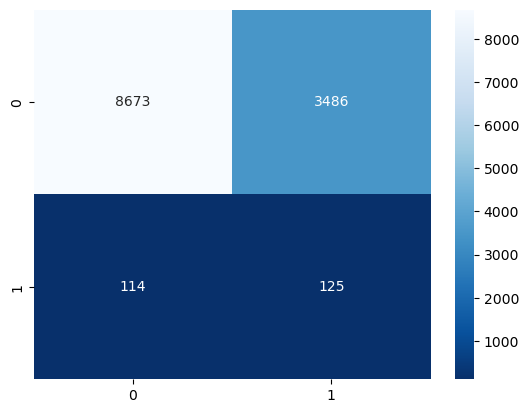

In [103]:
cm = confusion_matrix(y_test, preds_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');

In [104]:
print(f'Precision = ',precision_score(y_test, preds_test))

Precision =  0.03461644973691498


Мы видим, что наша модель намного чаще делает ошибки первого рода - предсказывает, что покупатель, который на самом деле ничего не купит, сделает покупку. За это отвечает метрика precision.

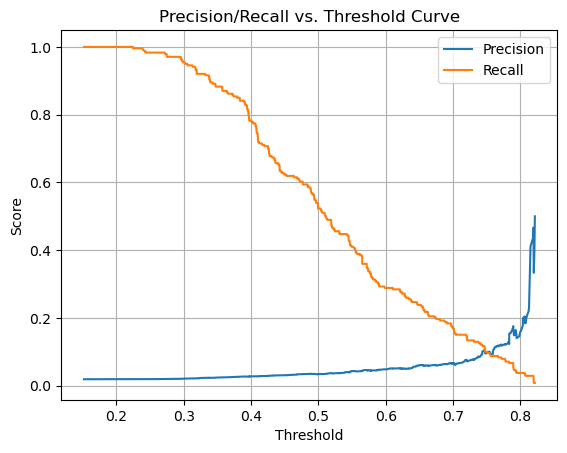

In [105]:
precision, recall, thresholds = precision_recall_curve(y_test, proba_class[:,1])
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision/Recall vs. Threshold Curve')
plt.grid(True)
plt.show()

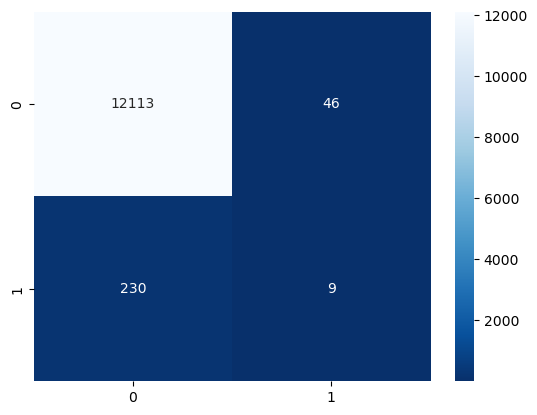

In [106]:
threshold = 0.8
y_pred = (proba_class[:, 1] > threshold).astype('float')
cm_2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues_r');

С порогом 0.75 наша модель будет меньше совершать False Positive ошибок. #но при этом почти не будет true positive... я confused...

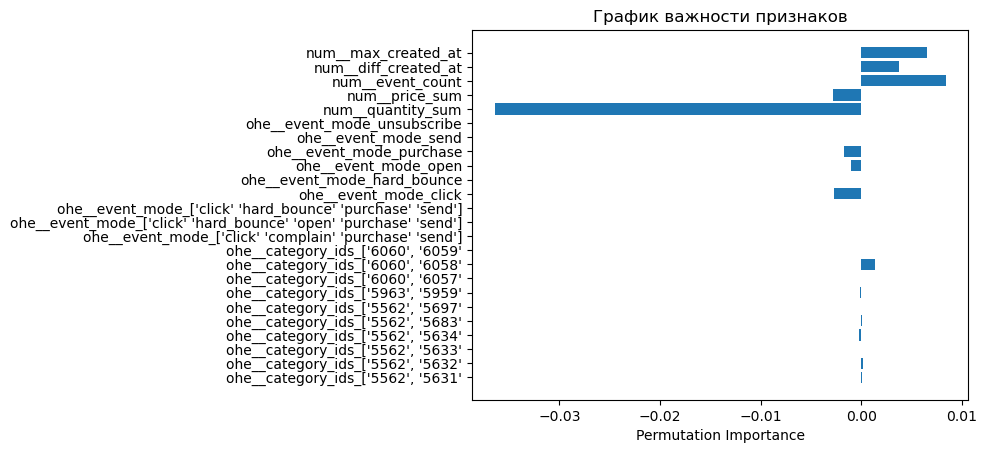

In [107]:
perm_importance = permutation_importance(randomized_search.best_estimator_.named_steps['models'],
                                         X_test, y_test)

feature_names = X_test.columns
features = np.array(feature_names)

sorted_idx = ((np.sort(perm_importance.importances_mean)).argsort())>30
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('График важности признаков');

Больше всего на вероятность покупки влияют такие признаки как кол-во типов действий, разница между первой и последней рекламной коммуникацией и последний год отправки рекламной коммуникации. Также немного влияют товары из категории 6060, и подкатегории 6058. Отрицательно влияют кол-во товаров и стоимость.

#я вообще не очень поняла, почему на матрице корреляции у меня кол-во товаров и стоимость положительно влияли на целевой признак, а здесь отрицательно...
про этот проект я могу сказать то что я чувствую, что я где-то совершила мажорную ошибку, но не могу ее найти...

## Вывод

Мы выяснили, что чаще всего пользователи получают рекламную рассылку с помощью почту, также большинство рассылок не открываются клиентами, но 26% их открывают, а еще 20% кликают на товары в этих рассылках. Больше всего рассылок пользователи получили в 2022 и 2023 годах. Подавляющее большинство клиентов получают рассылки уже два года. Чаще всего пользователи приобретают от 1 до 4 товаров и тратят на это до 10 000 тысяч рублей. 

Благодаря нашему исследованию нам удалось создать  модель, которая прогнозирует вероятность покупки и выявить признаки, которые больше всего влияют на наш целевой признак. 

Перед тем, как приступить к исследовательскому анализу, мы провели предобработку данных: заполнили пропуски, искали явные и неявные дубликаты. Мы создали новые признаки - кол-во типов действий, стоимость товара на одного покупателя, кол-во товаров на одного покупателя, последний год рассылки, разница (в годах) между первой и последней рассылкой, а также мода типа рассылок.

В исследовательском анализе мы изучили признаки рекламных рассылок: чаще всего рассылки получают по почте, большинство рассылок имеют статус 'send', 26% рассылок открываются клиентами, а 20% кликают на товары. Больше всего рассылок было сделаны в 2022-23 годах. Большинство клиентов получают рассылки на протяжении двух лет и только 3% клиентов делают покупку. Чаще всего клиенты тратят до 10 000 тысяч рублей на покупку и приобретают 1-3 товара. 

Корреляционный анализ показал, что наш целевой признак больше всего коррелирует со количеством товаров, стоимостью товаров, кол-вом действий, последним годом рассылки, и разнице между первой и последней рассылкой. Мы также обнаружили сильную мультиколлинеарность между кол-вом товара, стоимостью товара и кол-вом типов действий.


Следующим шагом было создание пайплайна, которое найдет нам лучшую модель для прогноза статуса стартапа. Ею оказалась LGBMClassifier, которая показала 67% ROC-AUC метрики. Мы проанализировали прогнозы с помощью графика важности признаков признаков. Он показал нам, что кол-во типов действий, последний год рассылки и разница между первой и второй рассылкой больше всего влияют на вероятность покупки.